In [177]:
import requests
import pandas as pd
from io import StringIO
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from great_tables import GT, md
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}


In [116]:
base = "https://stats.ncaa.org"
allteams = pd.read_html("https://stats.ncaa.org/selection_rankings/nitty_gritties/37268",extract_links='body')[0]

In [182]:
r = requests.get("https://stats.ncaa.org/selection_rankings/nitty_gritties/37268", headers=headers)
soup = BeautifulSoup(r.text)
images = [img['src'] for img in soup.find_all('img')[1:]]

In [207]:
images_map = dict(zip(allteams.Team.apply(lambda x: x[0]).tolist(), images))

In [9]:
# Get data and game id for all games in the season
allGames = pd.DataFrame()
for team, teamid in tqdm(allteams.Team):
    games = pd.read_html(base + teamid,extract_links='body')[0]
    games = games.loc[0::2]
    games[['Result','GameID']] = games['Result'].tolist()
    games.dropna(subset='GameID',inplace=True)
    games['GameID'] = games['GameID'].apply(lambda x: x.split('/')[2])
    allGames = pd.concat([allGames,games])

allGames['Date'] = allGames['Date'].apply(lambda x: x[0])

100%|██████████| 360/360 [13:52<00:00,  2.31s/it]


In [25]:
# Save games data
allGames.to_csv('games_2023-24.csv',index=False)

In [3]:
allGames = pd.read_csv('games_2023-24.csv', header=0)
allGames

,Date,Opponent,Result,Attendance,GameID
0,11/06/2023,"('Bradley', '/teams/560625')",W 73-66,"('1,203', None)",3970221
1,11/11/2023,"('@ UTEP', '/teams/561157')",L 60-62,"('1,093', None)",3970806
2,11/14/2023,"('Utah St.', '/teams/561181')",L 60-62,"('462', None)",3971414
3,11/18/2023,"('Kansas @Kansas City, MO', '/teams/560831')",L 61-70,"('867', None)",3972102
4,11/22/2023,"('Chicago St. @Cleveland, OH (23-24 WBB Viking...",W 77-46,"('418', None)",3972603
...,...,...,...,...,...
11454,03/02/2024,"('Saint Francis (PA)', '/teams/561057')",W 56-24,"('656', None)",3984511
11455,03/11/2024,"('#7 Stonehill 23-24 WBB NEC Tournament', '/te...",W 79-59,"('181', None)",5249793
11456,03/14/2024,"('#3 FDU 23-24 WBB NEC Tournament', '/teams/56...",W 52-38,"('214', None)",5249791
11457,03/17/2024,"('#1 Sacred Heart 23-24 WBB NEC Tournament', '...",L 48-69,"('1,467', None)",5249789


In [39]:
for row in tqdm(allGames.GameID,total=allGames.drop_duplicates('GameID').shape[0]):
    row


11459it [00:00, 641834.99it/s]          


In [37]:
allGames.drop_duplicates('GameID').shape[0]

5899

In [40]:
allJumpballs = pd.DataFrame()

for ix, row in tqdm(allGames.drop_duplicates('GameID').iterrows(), total=allGames.drop_duplicates('GameID').shape[0]):
    r = requests.get(base + f'/contests/{row.GameID}/play_by_play', headers=headers)
    pbp = [quarter for quarter in pd.read_html(StringIO(r.text), header=0) if 'Time' in quarter.columns]

    # Add quarter to pbp
    for q, table in enumerate(pbp):
        table.insert(0,'Quarter',q+1)
        
    pbp = pd.concat(pbp).reset_index(drop=True)
    team1 = pbp.loc[~pbp.iloc[:,-1].isna(),pbp.columns[-1]].to_frame('text')
    team1['team'] = pbp.columns[-1]
    team2 = pbp.loc[~pbp.iloc[:,2].isna(),pbp.columns[2]].to_frame('text')
    team2['team'] = pbp.columns[2]

    combinedDesc = pd.concat([team1,team2]).sort_index()
    combinedDesc.loc[combinedDesc.index.duplicated(keep='last'),'team'] = None
    combinedDesc = combinedDesc.loc[~combinedDesc.index.duplicated()]

    pbp[['text','team']] = combinedDesc

    jumpballs = pbp.loc[(pbp.text.str.contains('jumpball won')) | (pbp.text.str.contains('jumpball lost')),['Quarter','text','team']]
    jumpballs['gameID'] = row.GameID
    jumpballs['Date'] = row.Date

    allJumpballs = pd.concat([allJumpballs,jumpballs])   

  0%|          | 0/5899 [00:00<?, ?it/s]

100%|██████████| 5899/5899 [1:08:36<00:00,  1.43it/s]


In [94]:
jumpballsDf = allJumpballs.copy()
jumpballsDf[['Player','WL']] = jumpballsDf.text.str.split(', ').tolist()
jumpballsDf.to_csv('jumpball_data_2023_24.csv')

In [8]:
jumpballsDf = pd.read_csv('jumpball_data_2023_24.csv', index_col=0).reset_index(drop=True)
jumpballsDf

,Quarter,text,team,gameID,Date,Player,WL
0,1,"Ifunanya Nwachukwu, jumpball lost",Kansas City,3970221,11/06/2023,Ifunanya Nwachukwu,jumpball lost
1,1,"Daija Powell, jumpball won",Bradley,3970221,11/06/2023,Daija Powell,jumpball won
2,1,"Ifunanya Nwachukwu, jumpball won",Kansas City,3970806,11/11/2023,Ifunanya Nwachukwu,jumpball won
3,1,"Jane Asinde, jumpball lost",UTEP,3970806,11/11/2023,Jane Asinde,jumpball lost
4,1,"Ifunanya Nwachukwu, jumpball won",Kansas City,3971414,11/14/2023,Ifunanya Nwachukwu,jumpball won
...,...,...,...,...,...,...,...
12289,1,"Cameron Ward, jumpball lost",Stonehill,5249793,03/11/2024,Cameron Ward,jumpball lost
12290,1,"Olivia Russell, jumpball lost",Tex. A&M-Commerce,3970229,11/06/2023,Olivia Russell,jumpball lost
12291,1,"Haylee Jordan, jumpball won",LeTourneau,3970229,11/06/2023,Haylee Jordan,jumpball won
12292,1,"ZyUnn Cormier, jumpball lost",UNT Dallas,3970551,11/10/2023,ZyUnn Cormier,jumpball lost


In [9]:
jumpballsDf.groupby(['team','Player'])['Player'].count()

team                Player            
A&M-Corpus Christi  Alecia Westbrook      26
                    Bruna Anguera          2
                    Nabaweeyah McGill      5
                    Tymberlin Criswell     1
AUM                 Danielle Luckey        1
                                          ..
Xavier              Nila Blackford        19
                    Tae'lor Purvis         1
Yale                Brenna McDonald       28
Youngstown St.      Emily Saunders        31
                    Lindsey Linard         1
Name: Player, Length: 1327, dtype: int64

In [118]:
# Team 
# -----------------------------------
teamWL = pd.DataFrame({'lost':jumpballsDf.query('WL == "jumpball lost"').value_counts(['team']), 
                       'won':jumpballsDf.query('WL == "jumpball won"').value_counts(['team'])})
teamWL.fillna(0, inplace=True)
teamWL['total'] = (teamWL.lost + teamWL.won)
teamWL['win%']  = teamWL.won / teamWL.total

teamWL.query('total >10').sort_values('win%',ascending=False)

,lost,won,total,win%
team,,,,
LSU,3.0,33.0,36.0,0.916667
Jackson St.,3.0,30.0,33.0,0.909091
Missouri St.,3.0,30.0,33.0,0.909091
UCLA,4.0,33.0,37.0,0.891892
Tulsa,4.0,32.0,36.0,0.888889
...,...,...,...,...
Stonehill,26.0,4.0,30.0,0.133333
Western Mich.,28.0,3.0,31.0,0.096774
St. Bonaventure,28.0,2.0,30.0,0.066667


In [155]:
freqJumper = [jumpballsDf.groupby(['team','Player'])['Player'].count().loc[team].sort_values(ascending=False).index[0] for team in team_plot.loc[:,'Team']]

GT(_tbl_data=                  img            Team  Win Rate  Average Height Margin  \
0             LSU.jpg             LSU  0.916667              -0.472222   
1     Jackson St..jpg     Jackson St.  0.909091               2.366667   
2    Missouri St..jpg    Missouri St.  0.909091               1.909091   
3            UCLA.jpg            UCLA  0.891892               2.764706   
4           Tulsa.jpg           Tulsa  0.888889               0.200000   
5       Idaho St..jpg       Idaho St.  0.870968               0.689655   
6         UAlbany.jpg         UAlbany  0.843750               0.892857   
7  South Carolina.jpg  South Carolina  0.842105               3.210526   
8        Portland.jpg        Portland  0.833333               3.812500   
9        Ohio St..jpg        Ohio St.  0.823529              -1.451613   

  Most Frequent Jumper  
0          Angel Reese  
1        Angel Jackson  
2        Jade Masogayo  
3         Lauren Betts  
4    Temira Poindexter  
5          Laura Bello  
6           Deja Evans  
7      Kamilla Cardoso  
8        Lucy Cochrane  
9       Taylor Thierry  , _body=<great_tables._gt_data.Body object at 0x000002514F330FB0>, _boxhead=Boxhead([ColInfo(var='img', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='Team', type=<ColInfoTypeEnum.default: 1>, column_label='Team', column_align='left', column_width=None), ColInfo(var='Win Rate', type=<ColInfoTypeEnum.default: 1>, column_label='Win Rate', column_align='right', column_width=None), ColInfo(var='Average Height Margin', type=<ColInfoTypeEnum.default: 1>, column_label='Average Height Margin', column_align='right', column_width=None), ColInfo(var='Most Frequent Jumper', type=<ColInfoTypeEnum.default: 1>, column_label='Most Frequent Jumper', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000002514F330B30>, _spanners=Spanners([]), _heading=Heading(title='Best Jump Ball Win Rates', subtitle="2023-24 Women's College Basketball", preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000025152B68F50>, _formats=[<great_tables._gt_data.FormatInfo object at 0x0000025152B6A120>, <great_tables._gt_data.FormatInfo object at 0x0000025152B6BE00>, <great_tables._gt_data.FormatInfo object at 0x0000025152B680E0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top
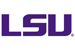
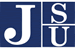
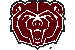
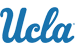
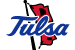
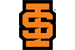
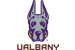
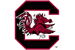
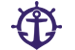
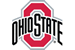

In [231]:
team_plot = teamWL.query('total >10').sort_values('win%',ascending=False).reset_index()
team_plot.columns = ['Team', 'Lost', 'Won', 'Games', 'Win Rate']
team_plot['Average Height Margin'] = team_plot.Team.map({team:sum(diffs) / len(diffs) for team, diffs in htDiffTeam.items()})
team_plot['Most Frequent Jumper'] = freqJumper
team_plot['img'] = team_plot.Team.apply(lambda team: f'{team}.jpg')
team_gt1 = GT(team_plot[['img','Team','Win Rate','Average Height Margin','Most Frequent Jumper']].head(10)).tab_header(title='Best Jump Ball Win Rates', 
                                                                               subtitle="2023-24 Women's College Basketball")
team_gt1 = team_gt1.fmt_percent(columns='Win Rate',decimals=1).fmt_number(columns='Average Height Margin', decimals=1, pattern="{x} in.")
team_gt1 = team_gt1.fmt_image(columns='img', path='./Logos').cols_label(img='')
team_gt1.opt_stylize(style=5)

In [ ]:
a={team:sum(diffs) / len(diffs) for team, diffs in htDiffTeam.items()}
pd.DataFrame(a,index=[0]).T.sort_values(0)

GT(_tbl_data=                     img             Team  Win Rate  Average Height Margin  \
359             Utah.jpg             Utah  0.027778              -1.593750   
358   William & Mary.jpg   William & Mary  0.033333              -0.827586   
357  St. Bonaventure.jpg  St. Bonaventure  0.066667              -1.966667   
356    Western Mich..jpg    Western Mich.  0.096774              -0.310345   
355        Stonehill.jpg        Stonehill  0.133333              -1.700000   
354         Maryland.jpg         Maryland  0.147059              -1.030303   
352          McNeese.jpg          McNeese  0.156250               0.037037   
351        Marquette.jpg        Marquette  0.156250               0.437500   
353      Southern U..jpg      Southern U.  0.156250              -1.620690   
350  CSU Bakersfield.jpg  CSU Bakersfield  0.166667              -2.541667   

    Most Frequent Jumper  
359        Jenna Johnson  
358     Anahi-Lee Cauley  
357        Taylor Napper  
356        Jasmine Elder  
355         Cameron Ward  
354      Shyanne Sellers  
352          Alva Mofalk  
351          Liza Karlen  
353           Sky Castro  
350     Garrisen Freeman  , _body=<great_tables._gt_data.Body object at 0x000002514F407590>, _boxhead=Boxhead([ColInfo(var='img', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='Team', type=<ColInfoTypeEnum.default: 1>, column_label='Team', column_align='left', column_width=None), ColInfo(var='Win Rate', type=<ColInfoTypeEnum.default: 1>, column_label='Win Rate', column_align='right', column_width=None), ColInfo(var='Average Height Margin', type=<ColInfoTypeEnum.default: 1>, column_label='Average Height Margin', column_align='right', column_width=None), ColInfo(var='Most Frequent Jumper', type=<ColInfoTypeEnum.default: 1>, column_label='Most Frequent Jumper', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000002514F333560>, _spanners=Spanners([]), _heading=Heading(title='Worst Jump Ball Win Rates', subtitle="2023-24 Women's College Basketball", preheader=None), _stubhead=None, _source_notes=['Viz. by Calvin Finley', Md(text='Data from NCAA Stats')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000002514F406540>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000002514F41FF80>, <great_tables._gt_data.FormatInfo object at 0x000002514F44FAD0>, <great_tables._gt_data.FormatInfo object at 0x000002514F5ACF80>, <great_tables._gt_data.FormatInfo object at 0x000002514F331250>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_i
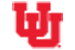
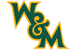
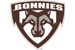
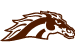
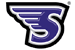
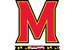
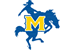
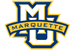
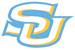
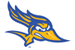

In [236]:
team_gt2 = ( GT(team_plot[['img','Team','Win Rate','Average Height Margin','Most Frequent Jumper']]
                .sort_values('Win Rate').head(10))
            .tab_header(title='Worst Jump Ball Win Rates', subtitle="2023-24 Women's College Basketball")
            .tab_source_note(source_note='Viz. by Calvin Finley')
            .tab_source_note(source_note=md('Data from NCAA Stats'))
)
team_gt2 = team_gt2.fmt_number(columns='Games',decimals=0).fmt_percent(columns='Win Rate',decimals=1).fmt_number(columns='Average Height Margin', decimals=1, pattern="{x} in.").fmt_image(columns='img', path='./Logos')
team_gt2 = team_gt2.cols_label(img='').cols_align(columns=['Win Rate','Average Height Margin'], align='right')
team_gt2 = team_gt2.opt_stylize(style=5, color='red')
team_gt2#.save('worst_jump_ball.png',scale=3)

# Players

In [246]:
roster = pd.read_csv('rosters_2023_24.csv')
roster.loc[roster.Name=='Ava Uhrich', 'Height'] = '6-0'
roster

,GP,GS,#,Name,Class,Position,Height,Hometown,High School,team,teamID
0,30,14,24,Zaire Harrell,So.,G,5-8,"Saint Louis, MO",Mary Institute and Saint Louis County Day School,Kansas City,560547
1,30,15,41,Jocelyn Ewell,Sr.,F,6-2,"Mission Viejo, CA",Santa Margarita Catholic,Kansas City,560547
2,28,6,5,Tamia Ugass,Jr.,F,6-3,"Saint Paul, MN",Roseville Area,Kansas City,560547
3,32,22,0,Emani Bennett,Fr.,G,5-11,"Lees Summit, MO",Lee's Summit North,Kansas City,560547
4,27,12,11,Kelby Bannerman,So.,F,6-1,"Hampshire, IL",Hampshire,Kansas City,560547
...,...,...,...,...,...,...,...,...,...,...,...
5077,15,0,12,Sydney Postell,Fr.,F,5-10,"Churchville, NY",Churchville-Chili,Le Moyne,561728
5078,12,0,11,Zhara Adeyemi,Fr.,G,5-10,"Brooklyn, NY",South Shore,Le Moyne,561728
5079,8,0,14,Kaitlyn Walker,Sr.,F,6-1,"Camillus, NY",West Genesee,Le Moyne,561728
5080,33,33,1,Lytoya Baker,Sr.,G,5-9,"Rochester, NY",NaN,Le Moyne,561728


In [315]:
player_team_map = dict(zip(roster.Name, roster.team))

In [243]:
def getPlayerHeight(name):
    try:
        return roster.loc[roster.Name==name.strip(),'Height'].item()
    except: # Series.item() returns an error if len !=0 (i.e. when player's name isn't in the roster table)
        return None

def feetToInches(height):
    return int(height.split('-')[0])*12+int(height.split('-')[1])

height_map = dict(zip(roster.Name, roster.Height))

In [354]:
print('Average height of all players: ', roster.query('Height!="-"').Height.apply(feetToInches).mean().round(1))
print('Average height of all jumpers: ', jumpballsDf.Player.map(height_map).dropna().apply(feetToInches).mean().round(1))

Average height of all players:  70.6
Average height of all jumpers:  73.8


In [234]:
jumpballsDf.loc[jumpballsDf.Player=="D'Shantae Edwards"]

,Quarter,text,team,gameID,Date,Player,WL
3,1,"D'Shantae Edwards, jumpball won",Bethune-Cookman,3983092,02/17/2024,D'Shantae Edwards,jumpball won


In [15]:
# Individual 
# -----------------------------------
playerWL = pd.DataFrame({'lost':jumpballsDf.query('WL == "jumpball lost"').value_counts(['Player']), 
                       'won':jumpballsDf.query('WL == "jumpball won"').value_counts(['Player'])})
playerWL.fillna(0, inplace=True)
playerWL['total'] = (playerWL.lost + playerWL.won)
playerWL['win%']  = playerWL.won / playerWL.total

# Get rid of MultiIndex
playerWL = playerWL.reset_index().set_index('Player')

# Add player heights
playerWL['Height'] = playerWL.index.to_series().apply(getPlayerHeight)

#playerWL.dropna(subset='Height', inplace=True)

playerWL.query('total >5').sort_values('win%',ascending=False).loc['Tierra Simon']

lost       4.0
won        6.0
total     10.0
win%       0.6
Height     6-1
Name: Tierra Simon, dtype: object

In [ ]:
playerWL.loc[playerWL.Height.isna()].sort_values("total",ascending=False)

In [17]:
playerWL.dropna(subset='Height', inplace=True)

In [18]:
playerWL.loc[~playerWL.Height.str[0].isin(['5','6'])]

,lost,won,total,win%,Height
Player,,,,,


In [291]:
playerWL.loc['Ava Uhrich', 'Height'] = '6-0'

In [19]:
playerWL['heightInches'] = playerWL.Height.apply(lambda h: int(h.split('-')[0])*12+int(h.split('-')[1]))
playerWL

,lost,won,total,win%,Height,heightInches
Player,,,,,,
A'Jah Davis,0.0,2.0,2.0,1.000000,6-1,73
Aaliyah Duranham,3.0,1.0,4.0,0.250000,5-9,69
Aaliyah Edwards,13.0,23.0,36.0,0.638889,6-3,75
Aaliyah Parker,1.0,0.0,1.0,0.000000,5-9,69
Aaliyah Roberson,7.0,0.0,7.0,0.000000,6-2,74
...,...,...,...,...,...,...
Zena Elias,3.0,2.0,5.0,0.400000,6-2,74
ZiKeyah Carter,2.0,0.0,2.0,0.000000,6-6,78
Zoe McCrary,8.0,14.0,22.0,0.636364,6-2,74


In [314]:
playerWL.query(f'total>={10}').sort_values('win%', ascending=False).head(15)

,lost,won,total,win%,Height,heightInches
Player,,,,,,
Kelby Bannerman,0.0,11.0,11.0,1.000000,6-1,73
Temira Poindexter,1.0,31.0,32.0,0.968750,6-2,74
Lauren Betts,2.0,28.0,30.0,0.933333,6-7,79
Jade Masogayo,3.0,29.0,32.0,0.906250,6-3,75
Angel Jackson,3.0,28.0,31.0,0.903226,6-5,77
Angel Reese,3.0,27.0,30.0,0.900000,6-3,75
Jaelyn Batts,1.0,9.0,10.0,0.900000,6-0,72
Amiya Joyner,3.0,21.0,24.0,0.875000,6-2,74
Laura Bello,4.0,26.0,30.0,0.866667,6-3,75


GT(_tbl_data=                 img             Player Height  Jump Balls  Win Rate
0          Tulsa.jpg  Temira Poindexter    6-2        32.0  0.968750
1           UCLA.jpg       Lauren Betts    6-7        30.0  0.933333
2   Missouri St..jpg      Jade Masogayo    6-3        32.0  0.906250
3    Jackson St..jpg      Angel Jackson    6-5        31.0  0.903226
4            LSU.jpg        Angel Reese    6-3        30.0  0.900000
5  East Carolina.jpg       Amiya Joyner    6-2        24.0  0.875000
6      Idaho St..jpg        Laura Bello    6-3        30.0  0.866667
7        UAlbany.jpg         Deja Evans    6-2        29.0  0.862069
8       Portland.jpg      Lucy Cochrane    6-6        35.0  0.857143
9      Boston U..jpg     Caitlin Weimar    6-4        34.0  0.823529, _body=<great_tables._gt_data.Body object at 0x0000025152F7A3F0>, _boxhead=Boxhead([ColInfo(var='img', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='Player', type=<ColInfoTypeEnum.default: 1>, column_label='Player', column_align='left', column_width=None), ColInfo(var='Height', type=<ColInfoTypeEnum.default: 1>, column_label='Height', column_align='right', column_width=None), ColInfo(var='Jump Balls', type=<ColInfoTypeEnum.default: 1>, column_label='Jump Balls', column_align='right', column_width=None), ColInfo(var='Win Rate', type=<ColInfoTypeEnum.default: 1>, column_label='Win Rate', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000025152F7A9F0>, _spanners=Spanners([]), _heading=Heading(title='Top Individual Jump Ball Win Rates', subtitle="2023-24 Women's College Basketball", preheader=None), _stubhead=None, _source_notes=[Md(text="*Minimum 50% of team's jump balls attempted*")], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000025152F7AFF0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x0000025152F7A300>, <great_tables._gt_data.FormatInfo object at 0x0000025152F7B080>, <great_tables._gt_data.FormatInfo object at 0x0000025152F7ACF0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='3px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#D5D5D5'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_right_width=OptionsInfo(scss=True
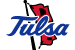
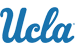
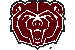
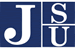
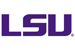
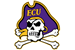
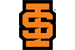
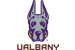
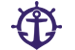
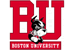

In [345]:
player_plot = playerWL.query('total >12').sort_values('win%',ascending=False).reset_index()
player_plot.columns = ['Player', 'Lost', 'Won', 'Jump Balls', 'Win Rate','Height','heightInches']
player_plot['Team'] = player_plot.Player.map(player_team_map)
player_plot['img'] = player_plot.Team.apply(lambda team: f'{team}.jpg')
player_gt = (GT(player_plot[['img','Player','Height','Jump Balls','Win Rate']].head(10))
             .tab_header(title='Top Individual Jump Ball Win Rates', subtitle="2023-24 Women's College Basketball")
             .tab_source_note(source_note=md(f"*Minimum 50% of team's jump balls attempted*"))
             )
player_gt = player_gt.fmt_percent(columns='Win Rate',decimals=1).fmt_number(columns='Jump Balls',decimals=0)
player_gt = player_gt.fmt_image(columns='img', path='./Logos').cols_label(img='')
player_gt.opt_stylize(style=5)

GT(_tbl_data=                 img             Player Height  Jump Balls  Win Rate
0  San Francisco.jpg  Debora Dos Santos    6-0        27.0  0.740741
1   UC San Diego.jpg      Katie Springs    6-0        19.0  0.736842
2   Grand Canyon.jpg       Tiarra Brown    5-9        28.0  0.714286
3       Winthrop.jpg    Marissa Gasaway   5-11        30.0  0.700000
4   Old Dominion.jpg  Simone Cunningham   5-10        32.0  0.656250
5          Brown.jpg       Ada Anamekwe    6-0        26.0  0.653846
6      Louisiana.jpg     Tamera Johnson   5-11        23.0  0.652174
7  Tennessee St..jpg         Lyric Cole    6-0        20.0  0.650000
8  Bowling Green.jpg       Erika Porter    6-0        24.0  0.625000
9            UNI.jpg   Shateah Wetering    6-0        29.0  0.620690, _body=<great_tables._gt_data.Body object at 0x0000025152ECA180>, _boxhead=Boxhead([ColInfo(var='img', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='Player', type=<ColInfoTypeEnum.default: 1>, column_label='Player', column_align='left', column_width=None), ColInfo(var='Height', type=<ColInfoTypeEnum.default: 1>, column_label='Height', column_align='right', column_width=None), ColInfo(var='Jump Balls', type=<ColInfoTypeEnum.default: 1>, column_label='Jump Balls', column_align='right', column_width=None), ColInfo(var='Win Rate', type=<ColInfoTypeEnum.default: 1>, column_label='Win Rate', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000025152EA4200>, _spanners=Spanners([]), _heading=Heading(title='Top Individual Jump Ball Win Rates (2023-24)', subtitle="Among players 6' and under", preheader=None), _stubhead=None, _source_notes=[Md(text="*Minimum 50% of team's jump balls attempted*")], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000025152F99130>, _formats=[<great_tables._gt_data.FormatInfo object at 0x0000025152F98290>, <great_tables._gt_data.FormatInfo object at 0x0000025152F98140>, <great_tables._gt_data.FormatInfo object at 0x0000025152F98E00>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='3px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#D5D5D5'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_right_width=OptionsInfo(scss=Tr
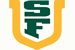
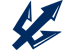
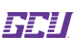
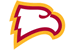
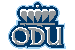
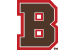
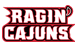
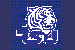
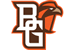
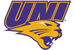

In [346]:
player_plot = playerWL.query('total >14').query('heightInches<=72').sort_values('win%',ascending=False).reset_index()
player_plot.columns = ['Player', 'Lost', 'Won', 'Jump Balls', 'Win Rate','Height','heightInches']
player_plot['Team'] = player_plot.Player.map(player_team_map)
player_plot['img'] = player_plot.Team.apply(lambda team: f'{team}.jpg')
player_gt = (GT(player_plot[['img','Player','Height','Jump Balls','Win Rate']].head(10))
             .tab_header(title="Top Individual Jump Ball Win Rates (2023-24)", subtitle="Among players 6' and under")
             .tab_source_note(source_note=md(f"*Minimum 50% of team's jump balls attempted*"))
             )
player_gt = player_gt.fmt_percent(columns='Win Rate',decimals=1).fmt_number(columns='Jump Balls',decimals=0)
player_gt = player_gt.fmt_image(columns='img', path='./Logos').cols_label(img='')
player_gt.opt_stylize(style=5)

In [45]:
playerWL.value_counts('total').sort_index().head(10)

total
1.0     239
2.0      97
3.0      64
4.0      45
5.0      40
6.0      32
7.0      23
8.0      20
9.0      19
10.0     28
Name: count, dtype: int64

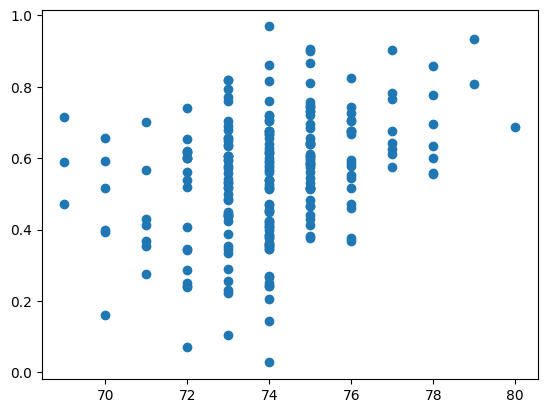

In [62]:
threshold = 25
plt.scatter(playerWL.loc[playerWL.total>=threshold,'heightInches'], playerWL.loc[playerWL.total>=threshold,'win%'])

In [114]:
playerWL.query(f'total>={threshold}').sort_values('win%', ascending=False).head(15)

,lost,won,total,win%,Height,heightInches
Player,,,,,,
Temira Poindexter,1.0,31.0,32.0,0.968750,6-2,74
Lauren Betts,2.0,28.0,30.0,0.933333,6-7,79
Jade Masogayo,3.0,29.0,32.0,0.906250,6-3,75
Angel Jackson,3.0,28.0,31.0,0.903226,6-5,77
Angel Reese,3.0,27.0,30.0,0.900000,6-3,75
Laura Bello,4.0,26.0,30.0,0.866667,6-3,75
Deja Evans,4.0,25.0,29.0,0.862069,6-2,74
Lucy Cochrane,5.0,30.0,35.0,0.857143,6-6,78
Caitlin Weimar,6.0,28.0,34.0,0.823529,6-4,76


In [69]:
playerWL.query('heightInches<72').query('total>5').sort_values('win%', ascending=False).head(10)

,lost,won,total,win%,Height,heightInches
Player,,,,,,
Ramatoulaye Keita,3.0,11.0,14.0,0.785714,5-11,71
Makoye Diawara,3.0,11.0,14.0,0.785714,5-11,71
Tiarra Brown,8.0,20.0,28.0,0.714286,5-9,69
Marissa Gasaway,9.0,21.0,30.0,0.700000,5-11,71
Perri Page,3.0,7.0,10.0,0.700000,5-11,71
Laniah Randle,2.0,4.0,6.0,0.666667,5-9,69
Simone Cunningham,11.0,21.0,32.0,0.656250,5-10,70
Tamera Johnson,8.0,15.0,23.0,0.652174,5-11,71
Iycez Adams,8.0,13.0,21.0,0.619048,5-11,71


In [303]:
playerWL.query('total>13').sort_values('heightInches', ascending=True).head(10)

,lost,won,total,win%,Height,heightInches
Player,,,,,,
Sarah Talon,14.0,20.0,34.0,0.588235,5-9,69
Lytoya Baker,18.0,16.0,34.0,0.470588,5-9,69
Tiarra Brown,8.0,20.0,28.0,0.714286,5-9,69
Quinesha Lockett,8.0,13.0,21.0,0.619048,5-10,70
Myra Bell,7.0,8.0,15.0,0.533333,5-10,70
Nalyce Dudley,11.0,16.0,27.0,0.592593,5-10,70
Blessing King,17.0,11.0,28.0,0.392857,5-10,70
Simone Cunningham,11.0,21.0,32.0,0.656250,5-10,70
Carley Duffney,10.0,6.0,16.0,0.375000,5-10,70


In [353]:
playerWL.sort_values('heightInches').head(20)

,lost,won,total,win%,Height,heightInches
Player,,,,,,
Shaunae Brown,1.0,0.0,1.0,0.000000,5-5,65
Eleyana Tafisi,1.0,0.0,1.0,0.000000,5-6,66
Aspen Thornton,1.0,0.0,1.0,0.000000,5-6,66
Aislynn Hayes,1.0,0.0,1.0,0.000000,5-6,66
Tae'lor Purvis,1.0,0.0,1.0,0.000000,5-7,67
Ahniysha Jackson,1.0,0.0,1.0,0.000000,5-7,67
D'Shantae Edwards,0.0,1.0,1.0,1.000000,5-7,67
Alyssa Durazo-Frescas,1.0,0.0,1.0,0.000000,5-7,67
Cheyenne Givens,2.0,0.0,2.0,0.000000,5-7,67


In [352]:
gamesDf.query('PlayerL.str.contains("Shaunae")')

,gameID,Date,TeamW,PlayerW,HeightW,heightInchesW,TeamL,PlayerL,HeightL,heightInchesL,heightDiff,GameWinner,JumpWinnerWonGame
3174,3980331,01/27/2024,Cal St. Fullerton,Fujika Nimmo,5-8,68,CSU Bakersfield,Shaunae Brown,5-5,65,3,CSU Bakersfield,False


**Height Differences**

In [20]:
comparisonDf = jumpballsDf.query('Quarter ==1').copy()
comparisonDf['Height'] = comparisonDf.Player.apply(getPlayerHeight)
comparisonDf.reset_index(drop=True,inplace=True)
comparisonDf

,Quarter,text,team,gameID,Date,Player,WL,Height
0,1,"Ifunanya Nwachukwu, jumpball lost",Kansas City,3970221,11/06/2023,Ifunanya Nwachukwu,jumpball lost,6-2
1,1,"Daija Powell, jumpball won",Bradley,3970221,11/06/2023,Daija Powell,jumpball won,6-2
2,1,"Ifunanya Nwachukwu, jumpball won",Kansas City,3970806,11/11/2023,Ifunanya Nwachukwu,jumpball won,6-2
3,1,"Jane Asinde, jumpball lost",UTEP,3970806,11/11/2023,Jane Asinde,jumpball lost,6-1
4,1,"Ifunanya Nwachukwu, jumpball won",Kansas City,3971414,11/14/2023,Ifunanya Nwachukwu,jumpball won,6-2
...,...,...,...,...,...,...,...,...
11729,1,"Cameron Ward, jumpball lost",Stonehill,5249793,03/11/2024,Cameron Ward,jumpball lost,5-10
11730,1,"Olivia Russell, jumpball lost",Tex. A&M-Commerce,3970229,11/06/2023,Olivia Russell,jumpball lost,5-11
11731,1,"Haylee Jordan, jumpball won",LeTourneau,3970229,11/06/2023,Haylee Jordan,jumpball won,None
11732,1,"ZyUnn Cormier, jumpball lost",UNT Dallas,3970551,11/10/2023,ZyUnn Cormier,jumpball lost,None


In [21]:
gamesWithNoHeight = comparisonDf.loc[comparisonDf.Height.isna()].gameID.unique()
comparisonDf.drop(index=comparisonDf.loc[comparisonDf.gameID.isin(gamesWithNoHeight)].index, inplace=True)

comparisonDf['heightInches'] = comparisonDf.Height.apply(lambda h: int(h.split('-')[0])*12+int(h.split('-')[1]))


In [22]:
heightDiffWins = defaultdict(list)
ct = 0
for ix, game in comparisonDf.groupby(comparisonDf.index // 2):
    height1 = game.at[ix*2,'heightInches']
    height2 = game.at[ix*2+1,'heightInches']
    p1Won   = 'won' in game.at[ix*2,'WL']

    if height1 > height2:
        heightDiffWins[height1-height2].append(1 if p1Won else 0)
    if height1 < height2:
        heightDiffWins[height2-height1].append(0 if p1Won else 1)


In [138]:
htDiffTeam = defaultdict(list)
for ix, game in comparisonDf.groupby(comparisonDf.index // 2):
    height1 = game.at[ix*2,'heightInches']
    height2 = game.at[ix*2+1,'heightInches']
    
    htDiffTeam[game.at[ix*2,'team']].append(height1 - height2)
    htDiffTeam[game.at[ix*2+1,'team']].append(height2 - height1)
    

In [37]:
for k in sorted(dict(heightDiffWins).keys()):
    v = heightDiffWins[k]
    print(k, round(sum(v) / len(v), 3), len(v))

1 0.542 1662
2 0.598 1215
3 0.636 720
4 0.604 477
5 0.67 270
6 0.764 123
7 0.792 48
8 0.611 18
9 1.0 7
10 0.0 2
11 1.0 1


In [97]:
comparisonDf.sort_values(['gameID', 'WL'], ascending=[True, True], inplace=True)
temp1 = comparisonDf.loc[comparisonDf.duplicated('gameID', keep='first')].reset_index(drop=True)
temp2 = comparisonDf.loc[comparisonDf.duplicated('gameID', keep='last')].reset_index(drop=True)
gamesDf = pd.concat([temp1,temp2], axis=1)
gamesDf.drop(columns=['text','Quarter'], inplace=True)

gamesDf.columns = ['TeamW', 'gameID', 'Date', 'PlayerW', 'WL', 'HeightW', 'heightInchesW',
       'TeamL', 'gameIDX', 'DateX', 'PlayerL', 'WL', 'HeightL', 'heightInchesL']
gamesDf.drop(columns=['WL','gameIDX','DateX'], inplace=True)

gamesDf = gamesDf[['gameID', 'Date', 'TeamW', 'PlayerW', 'HeightW', 'heightInchesW',
       'TeamL', 'PlayerL', 'HeightL', 'heightInchesL']]
gamesDf['heightDiff'] = gamesDf['heightInchesW'] - gamesDf['heightInchesL']
gamesDf.head(4)


,gameID,Date,TeamW,PlayerW,HeightW,heightInchesW,TeamL,PlayerL,HeightL,heightInchesL,heightDiff
0,3728200,11/06/2023,Monmouth,Belle Kranbuhl,6-3,75,Rutgers,Chyna Cornwell,6-3,75,0
1,3728201,11/09/2023,Rutgers,Chyna Cornwell,6-3,75,Wagner,Kiera Edmonds,6-2,74,1
2,3728202,11/12/2023,Auburn,Savannah Scott,6-4,76,Rutgers,Chyna Cornwell,6-3,75,1
3,3728203,11/15/2023,Seton Hall,Azana Baines,6-1,73,Rutgers,Chyna Cornwell,6-3,75,-2


In [107]:

gamesDf.sort_values('heightInchesW',ascending=True).head()

,gameID,Date,TeamW,PlayerW,HeightW,heightInchesW,TeamL,PlayerL,HeightL,heightInchesL,heightDiff
3996,3983092,02/17/2024,Bethune-Cookman,D'Shantae Edwards,5-7,67,Alcorn,Destiny Brown,6-3,75,-8
746,3971961,11/18/2023,Western Ky.,Acacia Hayes,5-8,68,Miami (OH),Katey Richason,6-1,73,-5
4423,3984100,02/27/2024,Marshall,CC Mays,5-8,68,Georgia St.,Deasia Merrill,6-1,73,-5
4380,3984020,02/24/2024,Ark.-Pine Bluff,Tia Morgan,5-8,68,Prairie View,Amauri Williams,6-4,76,-8
3749,3982281,02/10/2024,California Baptist,Chloe Webb,5-8,68,Utah Tech,Breaunna Gillen,5-9,69,-1


In [306]:
gamesDf.sort_values('heightDiff',ascending=True).head()

,gameID,Date,TeamW,PlayerW,HeightW,heightInchesW,TeamL,PlayerL,HeightL,heightInchesL,heightDiff,GameWinner,JumpWinnerWonGame
515,3971104,11/11/2023,Grand Canyon,Tiarra Brown,5-9,69,North Dakota,Miranda Vanderwal,6-7,79,-10,Grand Canyon,True
1671,3975338,12/16/2023,CSU Bakersfield,Jordan Olivares,5-8,68,Pepperdine,Megan Harkey,6-6,78,-10,Pepperdine,False
2669,3978528,01/14/2024,Alabama,Jessica Timmons,5-8,68,Arkansas,Maryam Dauda,6-4,76,-8,Arkansas,False
3428,3981124,02/03/2024,Air Force,Jayda McNabb,5-10,70,San Jose St.,Semaj Smith,6-6,78,-8,Air Force,True
1539,3974927,12/10/2023,Hampton,Cheyenne Talbot,5-9,69,New Mexico,Charlotte Kohl,6-5,77,-8,New Mexico,False


In [350]:
len(gamesDf.query("heightDiff>0")) / (len(gamesDf.query("heightDiff>0")) + len(gamesDf.query("heightDiff<0")))

0.5956416464891041

In [301]:
jumpballsDf.groupby(['team','Player'])['Player'].count().loc['Stetson']

Player
Diawna Carter-Hartley     3
Jaelyn Talley            15
Jamiya Turner            12
Skylar Treadwell          2
Sophia Fontaine           1
Name: Player, dtype: int64

# Game Win Rate

In [284]:
comparisonDf.loc[comparisonDf.duplicated('gameID', keep='first')]

,Quarter,text,team,gameID,Date,Player,WL,Height,heightInches
8525,1,"Belle Kranbuhl, jumpball won",Monmouth,3728200,11/06/2023,Belle Kranbuhl,jumpball won,6-3,75
10436,1,"Chyna Cornwell, jumpball won",Rutgers,3728201,11/09/2023,Chyna Cornwell,jumpball won,6-3,75
1833,1,"Savannah Scott, jumpball won",Auburn,3728202,11/12/2023,Savannah Scott,jumpball won,6-4,76
10438,1,"Azana Baines, jumpball won",Seton Hall,3728203,11/15/2023,Azana Baines,jumpball won,6-1,73
10441,1,"Chyna Cornwell, jumpball won",Rutgers,3728204,11/18/2023,Chyna Cornwell,jumpball won,6-3,75
...,...,...,...,...,...,...,...,...,...
6152,1,"Ruthie Udoumoh, jumpball won",Oral Roberts,5254446,03/21/2024,Ruthie Udoumoh,jumpball won,6-1,73
1358,1,"Deja Evans, jumpball won",UAlbany,5254447,03/21/2024,Deja Evans,jumpball won,6-2,74
9216,1,"Amelia Strong, jumpball won",Niagara,5254448,03/22/2024,Amelia Strong,jumpball won,6-2,74
2770,1,"Alexis Davis, jumpball won",Buffalo,5254450,03/21/2024,Alexis Davis,jumpball won,6-0,72


In [273]:
import re

d1Games = allGames.loc[allGames.GameID.duplicated()].GameID.tolist()
winnerDf = allGames.loc[allGames.GameID.isin(d1Games)].sort_values('GameID').reset_index(drop=True)
gameWinners = {}
for ix, game in winnerDf.groupby(winnerDf.index // 2):
    winner = eval(game.loc[game.Result.str.contains('L')].Opponent.iloc[0])[0]
    winner =  re.findall(r"[a-zA-Z. ()&']+",winner)[0].strip()
    gameWinners[int(game.GameID.iloc[0])] = winner

In [283]:
winnerDf

,Date,Opponent,Result,Attendance,GameID
0,11/06/2023,"('@ Rutgers', '/teams/561048')",L 51-56,"('1,403', None)",3728200
1,11/06/2023,"('Monmouth', '/teams/560910')",W 56-51,"('1,403', None)",3728200
2,11/09/2023,"('Wagner', '/teams/561200')",W 86-43,"('1,688', None)",3728201
3,11/09/2023,"('@ Rutgers', '/teams/561048')",L 43-86,"('1,688', None)",3728201
4,11/12/2023,"('@ Rutgers', '/teams/561048')",W 76-56,"('1,619', None)",3728202
...,...,...,...,...,...
11115,03/22/2024,"('Le Moyne 23-24 WBB WNIT', '/teams/561728')",W 91-86,"('809', None)",5254448
11116,03/21/2024,"('@ Buffalo 23-24 WBB WNIT', '/teams/560636')",W 68-58,"('710', None)",5254450
11117,03/21/2024,"('Monmouth 23-24 WBB WNIT', '/teams/560910')",L 58-68,"('710', None)",5254450
11118,03/21/2024,"('Bowling Green 23-24 WBB WNIT', '/teams/560623')",W 75-63,"('537', None)",5254451


In [293]:
gamesDf['GameWinner'] = gamesDf.gameID.map(gameWinners)
gamesDf['JumpWinnerWonGame'] = gamesDf.apply(lambda row: str(row.GameWinner) in str(row.TeamW), axis=1)

exceptions = gamesDf.loc[~((gamesDf.TeamW == gamesDf.GameWinner) | (gamesDf.TeamL == gamesDf.GameWinner))].copy()


In [294]:
gamesDf.JumpWinnerWonGame.sum() / len(gamesDf.index)

np.float64(0.5773364911641464)

In [308]:
gamesDf.loc[gamesDf.heightDiff<0].JumpWinnerWonGame.sum() / len(gamesDf.loc[gamesDf.heightDiff<0].index)

np.float64(0.5601524224278716)

In [310]:
gamesDf.loc[gamesDf.heightDiff>0].JumpWinnerWonGame.sum() / len(gamesDf.loc[gamesDf.heightDiff>0].index)

np.float64(0.5875831485587583)

In [358]:
from ncaa_pbp import Team

teams_list = []
for team in allteams.Team.apply(lambda x: x[1].split('/')[-1]):
    teams_list.append(Team(team,source='file'))

In [366]:
winPcts = {}
for teamobj, name in zip(teams_list, allteams.Team.apply(lambda x: x[0])):
    try:
        winPcts[name] = teamobj.games.Result.value_counts()['W'] / len(teamobj.games)
    except:
        winPcts[name] = 0

In [395]:
winPcts['FGCU']

np.float64(0.84375)

team              
A&M-Corpus Christi    0.558824
Abilene Christian     0.636364
Air Force             0.515152
Akron                 0.285714
Alabama               0.529412
                        ...   
Wright St.            0.270270
Wyoming               0.676471
Xavier                0.344828
Yale                  0.607143
Youngstown St.        0.687500
Name: win%, Length: 360, dtype: float64

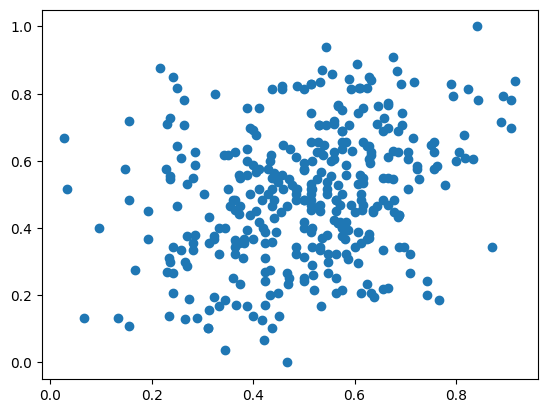

In [396]:
plt.scatter(teamWL.query('total>15')['win%'], teamWL.query('total>15').reset_index().team.map(winPcts))

In [409]:
(team_plot.head(20).Team.map(winPcts)>.5).sum()

np.int64(18)

In [388]:
for x, y in zip(teamWL.query('total>15').index, winPcts.keys()):
    print(x[0]==y)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals